# CMSC421 Final Project

Group Memebers: Aron Sun, Jie Zheng //type your name in

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from keras.models import Sequential
from keras.layers import Dense   
from keras import optimizers

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from keras.models import load_model
from keras import optimizers
from matplotlib import pyplot
from math import sqrt
from keras import optimizers
import tensorflow as tf

In [3]:
from datetime import datetime, timedelta
# load the data 
data_frame = pd.read_csv('us-counties.csv')

# Isolate out date for a single
df = data_frame[data_frame.state=='Texas']
df = data_frame.groupby(['date']).sum().reset_index()

# Convert date to a string
df['date'] = df['date'].astype("string")

# Using datetime to convert the date string to a numerical value
d2020 = datetime(year = 2020, month = 1, day = 21)

date_time = []
for i in np.arange(len(df)):
    date = (np.array(df['date'].iloc[i].split('-')))
    time = datetime(int(date[0]),int(date[1]),int(date[2]))
    date_time.append(2020+(time-d2020)/timedelta(days=365.2425))
date_time = np.array(date_time)


In [131]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from numpy import array

# Function that splits the data into input and ouput sequences
def split_seq(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence.iloc[i:end_ix], sequence.iloc[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# split the training and testing data
train_ind = int(len(df)*0.8)
train, test = train_test_split(df['cases'], test_size = 0.2, shuffle=False)
train_date, test_date = train_test_split(date_time, test_size = 0.2, shuffle=False)

# train = df['cases'][:train_ind]
# test = df['cases'][train_ind:]


# define hyperparameters
n_inputs = 3
batch_size = 20
n_features = 1
generator_train = TimeseriesGenerator(train, train, length=n_inputs, batch_size=batch_size)
train_in, train_out = split_seq(train, n_inputs)
test_in, test_out = split_seq(test, n_inputs)
train_out = np.expand_dims(train_out, axis=1)
test_out = np.expand_dims(test_out, axis=1)


# for i in range(len(generator_test)):
#     x, y = generator_test[i]
#     print('%s => %s' % (x, y))


# define model

model = Sequential()
# add hidden layer (LSTM)
model.add(LSTM(50, activation='relu', input_shape=(n_inputs, n_features)))
# add output layer
model.add(Dense(1))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# fit model
history = model.fit(generator_train,
                    validation_data = (test_in, test_out),
                    steps_per_epoch=1,
                    epochs=500,
                    verbose=0)

train_pred = model.predict(train_in, verbose=0)
test_pred = model.predict(test_in, verbose=0)

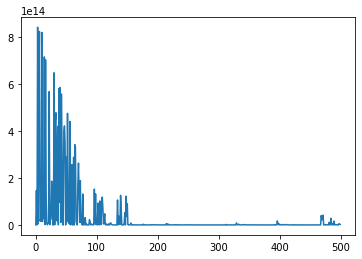

In [132]:
plt.plot(history.history['mean_squared_error'])

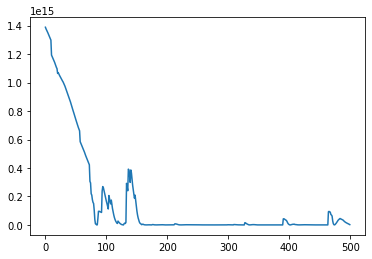

In [133]:
plt.plot(history.history['val_loss'])

In [134]:
# loss or mse over time for training
# train_mse = np.divide(np.abs(np.subtract(train_out, train_pred)), train_out)

# plt.plot(train_date[n_inputs:], train_mse)

# plt.axis([min(train_date), max(train_date), 0, max(train_mse)*1.1])
# plt.show()

In [135]:
# loss or mse over time for testing
# test_mse = np.square(np.subtract(test_out, test_pred))

# plt.plot(test_date[n_inputs:], test_mse)

# plt.axis([min(test_date), max(test_date), 0, max(test_mse)*1.1])
# plt.show()


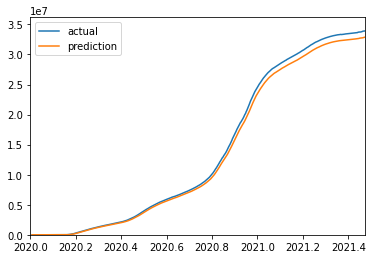

In [136]:
# training set actual vs prediction plot
plt.plot(train_date[n_inputs:], train_out)
plt.plot(train_date[n_inputs:], train_pred)

plt.axis([min(train_date), max(train_date), 0, max(train_pred)*1.1])
plt.legend(['actual', 'prediction'])
plt.show()

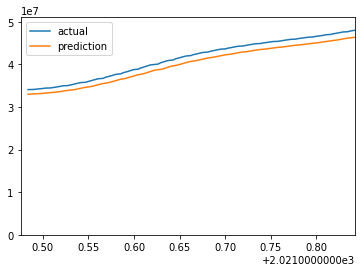

In [137]:
# testing set actual vs prediction plot
plt.plot(test_date[n_inputs:], test_out)
plt.plot(test_date[n_inputs:], test_pred)

plt.axis([min(test_date), max(test_date), 0, max(test_pred)*1.1])
plt.legend(['actual', 'prediction'])
plt.show()